# Product Clusters

## Introduction

The project is part of a challenge proposed by a brazilian retail company called Magazine Luiza and aims to create and interpret clusters of products sold by the company as well as predict the sales of each product.  Big retailers have the need to predict with high accuracy the sales for the next weeks or months. This is an important task because of main two reaons:

1. To sell a product to a customer, the company need to have it in a store or a factory stock. This impacts in the customers' experience and satisfaction with the company. Imagine, for example, if the company decides to keep few products in its factory's stock and the demand for them is high. Probably the company wouldn't sell as much as it could and would lose the opportunity to retain an important customer
2. To stock products in wharehouses or in the stores is expensive. Therefore, if the company buys more products than the demand, this would cause a negative impact in the company's finances. 

We also need to think about the variety of products sold by a big retailer company. Each product has a different behavior, some of them are seasonal, other ones are really sensible to prices, other ones are bought equally all year long.  Based on this, we can say it's not fair to treat every product equally. A possible approach is to clusterize them to understand tehir behavior and maybe create a prediction model that represents the behavior of each group. 

The main motivation to build this project as part of a challenge provided by a retailer company is that today I' currently working in a similar company that is facing similar problems. So this is a way to get prepared and provide better solutions in my professional life. 


## Problem Statement

The retailer company that proposed the challenge is growing up and needs to be more accurate in the sales prediction of each product. Considering the ideas presented in the **Background Section**, the company proposed to answer some questions:

1. **Grouping questions**: How can we group similar products? How these groups can be described and what is the ideal number of groups? 
2. **Sales questions**: how many products will be sold in the next few months? How can one evaluate its predictions? 

This project will focus on grouping similar products based on their features and transaction information. In other words, this project will present an unsupervised learning solution, more specifically a cluster of products, and it can be summarized as follows:

* Learning task:  we need to infer a function to describe hidden structure from "unlabeled" data (a classification or categorization is not included in the observations). This structure of the data will be calculated based on a distance metric of each product's feature. The algorithm will aim to reduce the distance between products and group the closest ones. 
* Input data: the input dataset will contain one product per line and each column will describe some feature of it, such as `mean_of_cost`, `mean_of_price`, `mean_of_revenue` and so on. It is important to highlight that the initial dataset (described in the following section) does not have this structure and some preprocessing in the data will be done. 
* Output data: the output will be the clusters that each product belongs to. This output will be combined with the input data in order to generate a final dataset that can be summarized (using `sklearn` functions) and interpreted.

The tasks involved are the following:

1. Explore	the	data,	check	it’s	behavior	of	the	transactions	and observe	how	the	variables	are	filled	and	which	type	of	information they	contain
2. Study	and	define	the	most	appropriate	cluster	technique	to	be used.	Some	research	will	be	done	in	order	to	evaluate	KMeans	and some	variations	(such	as	KMedians)	of	it.
3. Given the	clusters,	we	need	to	summarize	and	interpret	the	data.
4. We need to evaluate the cluster results and check if they are better than benchmark's results


## Metrics

We use silhouette score as a core metric to evaluate the quality of the clusters. The silhouette score is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters.

## Benchmark model

As this project is part of a challenge and it's not over yet, I was not able to get several benchmark results. So I asked a friend of mine to share his partial results in the clustering task and these will be used as a benchmark. The benchmark model used KMeans as a machine learning algorithm, with k=6 (randomly chosen), Euclidean as distance metric and with this set of arguments, the silhouette score was 0.45.

## Exploratory Data Analysis

In this section, we explore the basic characteristics of the dataset, not only its dimensions, but also characteristics of its variables.

The first few lines of code only load the required libs to run the project. 

The dataset contains the history of transactions from a big retailer. The categorical variables in the dataset were _hasherized_ in order to hide real names of products, orders, categories of products and so on, except two variables `order_status` and `process_status`. It has 179149 rows e 14 columns (called variables in this project). An example of it is shown below. It also has 8 categorical variables and and the other ones are numerical (one can see a summary of this information in the Table 01 below). 

It's also important to highlight that all variables have fill density of 100%. However, that variable `process_date` has some values equal to `0000-00-00`, that is not a valid format of data. These values will be transformed in `NaN` values to avoid inconsistencies and errors when using the `sklearn`. 

In [2]:
import pandas as pd
import numpy as np
import sys
import math
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
import visuals
import utils

df = pd.read_csv("data/challenge.csv")

In [36]:
df.head()

,order_id,code,quantity,price,pis_cofins,icms,tax_substitution,category,liquid_cost,order_status,capture_date,process_date,process_status,source_channel,revenue
0,bcb59c839e78b2601374cbad9239ca7b,e6762ba2ffbca07ab6cee7551caeaad5,1,978.90,90.5483,0.0000,191.8416,4ece547755cba9e7fc14125bc895f31b,542.7065,entrega total,2016-06-11,2016-06-11,processado,b76eb9b8fc0f17098812da9117d3e500,978.90
1,4e91ee6b95895771dc9ee524e910a902,e6762ba2ffbca07ab6cee7551caeaad5,1,1036.29,95.8568,176.1693,0.0000,4ece547755cba9e7fc14125bc895f31b,542.7065,em rota de entrega,2016-06-11,2016-06-11,processado,b76eb9b8fc0f17098812da9117d3e500,1036.29
2,88eb0ac86af1a521c0831298d22dea8b,e6762ba2ffbca07ab6cee7551caeaad5,1,978.90,90.5483,0.0000,191.8416,4ece547755cba9e7fc14125bc895f31b,542.7065,entrega total,2016-06-12,2016-06-12,processado,b76eb9b8fc0f17098812da9117d3e500,978.90
3,dee418152a36314b4aee6ce9cf94fcbf,e6762ba2ffbca07ab6cee7551caeaad5,1,978.90,90.5483,176.2020,0.0000,4ece547755cba9e7fc14125bc895f31b,542.7065,cancelado,2016-06-13,NaT,captado,b76eb9b8fc0f17098812da9117d3e500,978.90
4,1c175bc61b9b659bbf011b2e5e3dcec6,e6762ba2ffbca07ab6cee7551caeaad5,1,976.05,90.2846,0.0000,192.3325,4ece547755cba9e7fc14125bc895f31b,542.7065,entrega total,2016-06-13,2016-06-13,processado,b76eb9b8fc0f17098812da9117d3e500,976.05


In [4]:
utils.calculate_variable_density(df)



category                  => Density of 100.00%
code                      => Density of 100.00%
order_id                  => Density of 100.00%
tax_substitution          => Density of 100.00%
price                     => Density of 100.00%
capture_date              => Density of 100.00%
process_status            => Density of 100.00%
order_status              => Density of 100.00%
icms                      => Density of 100.00%
pis_cofins                => Density of 100.00%
process_date              => Density of 100.00%
liquid_cost               => Density of 100.00%
source_channel            => Density of 100.00%
quantity                  => Density of 100.00%


#### Table 01

| variable name    	| variable type 	|
|------------------	|---------------	|
| category         	| categorical   	|
| code             	| categorical   	|
| order_id         	| categorical   	|
| tax_substitution 	| numerical     	|
| price            	| numerical     	|
| capture_date     	| categorical   	|
| process_status   	| categorical   	|
| order_status     	| categorical   	|
| icms             	| numerical     	|
| pis_cofins       	| numerical     	|
| process_date     	| categorical   	|
| liquid_cost      	| numerical     	|
| source_channel   	| categorical   	|
| quantity         	| numerical     	|


From the chart below one can see that there are two product sales peaks, one on November 25, 2016 and another on January 6, 2017. Probably the first peak is due to the Black Friday and the second peak is due to the event of "Fantastic Liquidation" in which the store launched a big promotion to its customers. On other days the sales curve remains unchanged.

It's interesting to note that although the two dates above are highlighted in quantities of products sold they do not represent the days that gave the company more revenue (`revenue = quantity * price`). The most profitable day was September 29, 2016. The two dates above still remain among the top 5 most profitable days.

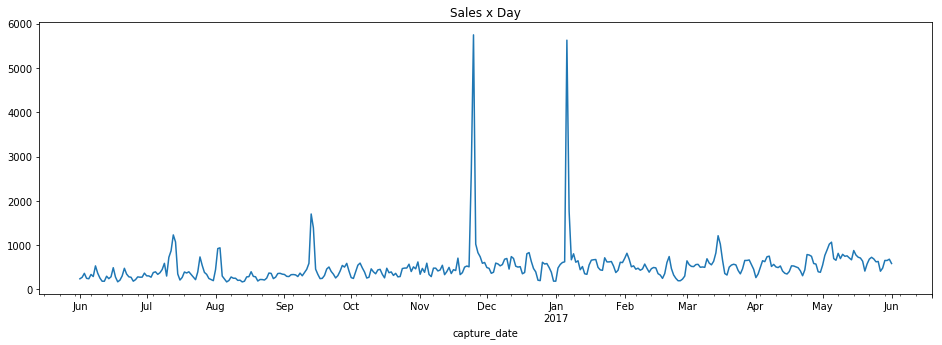

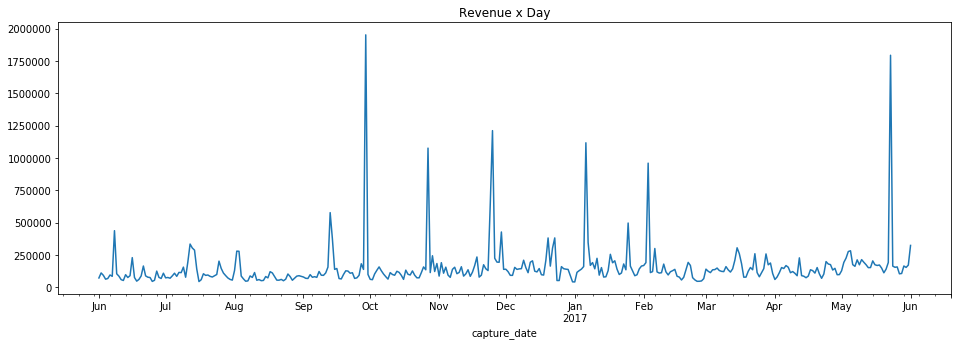

In [5]:
df['process_date'] = df['process_date'].apply(lambda x: np.nan if x == '0000-00-00' else x)
df['capture_date'] = pd.to_datetime(df['capture_date'], format="%Y/%m/%d")
df['process_date'] = pd.to_datetime(df['process_date'], format="%Y/%m/%d")

ts_quantity = df.groupby(pd.Grouper(key='capture_date', freq='D'))['quantity'].aggregate(np.sum)

df['revenue'] = df['quantity'] * df['price']

ts_revenue = df.groupby(pd.Grouper(key='capture_date', freq='D'))['revenue'].aggregate(np.sum)

plt.figure(figsize=(16,5))
plt.title("Sales x Day")
ts_quantity.plot()
plt.show()

plt.figure(figsize=(16,5))
plt.title("Revenue x Day")
ts_revenue.plot()
plt.show()

## Cluster implementation and analysis

In this section the cluster algorithm will be implemented. The algorithm chosen to perform this action is KMeans. The beginning of this section will explore the main characteristics of this technique. 

### KMeans attributes

In general, cluster algorithms can not handle categorical variables so well, since it is difficult to find a distance function that can represent them. For example, given the variable `COLOR` belonging to the dataset D and which may have the values [ red, green, blue, yellow ]. It is impossible to tell how close the red color is to the blue color. KMeans is based on the Euclidean distance between variables to assemble their clusters, and this measure, by definition, works only with continuous variables. This allows us to say that we must treat the categorical variables present in the dataset in order to cluster the products in the best possible way.

After some research, two main ways of dealing with this situation were identified:

1. **1-of-K Coding** [3]: consists of transforming all the categorical variables into dummy vars and applying the KMeans considering these new variables as continuous. This method, in spite of satisfactory results, drastically increases the number of variables present without a data set that can impair algorithm performance and also generate overfitting (when the cluster fails to generalize the data groupings).
2. **K-prototypes**[1][2][4]: this algorithm is based on KMeans and KModes. It is adapted to deal with a mix of categorical and continuous variables, using appropriate distance measures for each of these types. The trade-offs of this method lie in its implementation in python [6], which has poor performance when the dataset has more than ten thousand lines, and in the lack of clarity if the KMeans validation methods work for it as well (in the articles analyzed is not entirely clear).

### Preprocessing data

The original dataset contains the history of transactions of Magazine Luiza. This is not suitable to builder clusters of products. We need to create a new dataset indexed by product (code). In other words, each line of dataset must contain information about only one product and each column must contain their features (price, revenue, cost, taxes, statuses and so on). 

It's important to highlight the variables `order_status` and `process_status` will be treated as dummy vars (following the idea of **1-of-k coding**). After that, each dummy var will be summed in order to produce a product dataset containing numerical variables that count the number of times each status happened for each product. Moreover, all the _hasherized_ variables will be removed, since it's not possible to identify their meaning, therefore it would be pointless to keep them in the dataset. 

By the end of all transformations, the input dataset will contain only numerical variables, so it will be possible to use KMeans with Euclidean distance. 


In [6]:
df_order_status = pd.get_dummies(df['order_status'], prefix="order_status")
df_process_status = pd.get_dummies(df['process_status'], prefix="process_status")

df2 = pd.concat([df, df_order_status], axis=1)
df2 = pd.concat([df2, df_process_status], axis=1)


df_grouped = df2.groupby('code').agg({'quantity': np.mean, 'price': np.mean, 
                                     'pis_cofins': np.mean, 'tax_substitution': np.mean,
                                    'liquid_cost': np.mean, 'revenue': np.mean}).reset_index()

df_grouped2 = df2.groupby('code').agg(np.sum).reset_index()
df_grouped2 = df_grouped2[df_grouped2.columns.difference(['quantity', 'price', 'pis_cofins', 'icms',
                                                         'tax_substitution', 'liquid_cost', 'revenue'])]
# df_grouped2.head()
product_dataset = df_grouped.merge(df_grouped2, how='inner', on='code') 

product_dataset.head()

,code,revenue,tax_substitution,price,pis_cofins,liquid_cost,quantity,order_status_cancelado,order_status_cancelado boleto não pago,order_status_cancelado dados divergentes,...,order_status_entrega total,order_status_fraude confirmada,order_status_pendente processamento,order_status_processado,order_status_solicitação de cancelamento,order_status_solicitação de troca,order_status_suspeita de fraude,order_status_suspenso barragem,process_status_captado,process_status_processado
0,0671c2b9132a3f5215a4212ce0691694,225.445203,13.551533,213.213890,19.673568,117.0820,1.020166,182.0,1751.0,28.0,...,4151.0,6.0,0.0,32.0,28.0,93.0,2.0,0.0,1970.0,4526.0
1,09f544ec2a74c89abeec7b0590fc2d11,220.022618,11.664623,145.200961,13.410406,73.8002,1.085890,18.0,89.0,0.0,...,809.0,0.0,0.0,5.0,9.0,13.0,0.0,0.0,107.0,871.0
2,0ad316f6b5cb5e81ebff73ae2490ccfe,219.997219,11.489706,210.690798,19.373709,106.4842,1.020450,8.0,40.0,0.0,...,411.0,1.0,0.0,7.0,4.0,7.0,0.0,0.0,49.0,440.0
3,0bbe09e34a11e8e31cf49d6f8df2992d,187.256657,4.116640,167.754106,15.491333,88.9639,1.023460,8.0,40.0,1.0,...,266.0,1.0,0.0,3.0,3.0,9.0,0.0,0.0,51.0,290.0
4,0dca7ec6ba9b6e8f17f04f713a6be727,149.058133,2.273317,68.569957,6.341866,27.2847,1.419528,22.0,115.0,4.0,...,691.0,1.0,0.0,13.0,6.0,15.0,0.0,1.0,145.0,787.0


### KMeans implementation

A common challenge faced when dealing with KMeans is to define the best value of K. An interesting technique to solve this problem is the elbow method. It evaluates the percentage of variance that is explained as a function of the number of clusters. The ideal number of clusters happens when one adds another cluster and it doesn't give much better modeling of the data.

It's important to highlight that KMeans used with Euclidean distance is reallly sensible to outliers and big differences among features' values. So, we'll use `MinMaxScaler` function from `sklearn` to normalize the data. 

From the implementation below, it's possible to note the best value for K is 4. KMeans will be trained with `K = 4` and then the cluster values will be merged in the products' dataset previously created. 

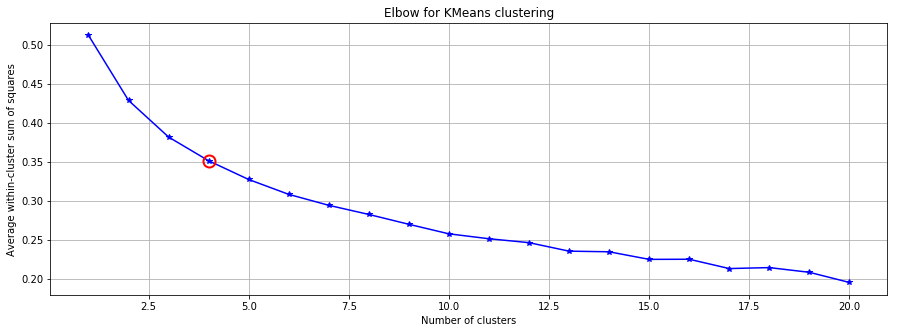

In [7]:
df3 = product_dataset[product_dataset.columns.difference(['code'])]

min_max_scaler = MinMaxScaler()
# PERFORM FEATURE SCALING
df3 = min_max_scaler.fit_transform(df3)
visuals.plot_elbow_curve(df3, range(1,21))

In [30]:
kmeans = KMeans(init='k-means++', n_clusters=4, random_state=30).fit(df3)
labels = kmeans.labels_
product_dataset['clusters'] = labels
# product_dataset.head()

### Cluster analysis

To study the main characteristics of each cluster, the function `describe` of `sklearn` will be used. Basically, we'll analyze the stats of each variable.

* **Cluster 0**: it's the cluster with the highest average revenue. Contains few products and they are usually purchased only one time (mean of quantity is 1.028). That is, it is the cluster with the most expensive products.
* **Cluster 1**: this is the cluster identified by cancellations. It has high averages of cancellation and they come from three main reasons: unpaid ticket, divergent data and requests made by the customer to cancel the purchase.
* **Cluster 2**: this is the cluster of cheap products. It has few cancellations and many finished processing (`process_status`).
* **Cluster 3**: this is the most balanced cluster in terms of features. It has no feature that stands out in relation to the other clusters, but it is important to point out that there are a considerable number of unpaid cancellations for this group

It's possible to check all cluster stats in the Jupyter Notebook (please refer the README.md file to learn how to run it).

In [31]:
# product_dataset[product_dataset.clusters == 0].describe(percentiles=[])

In [32]:
# product_dataset[product_dataset.clusters == 1].describe(percentiles=[])

In [33]:
# product_dataset[product_dataset.clusters == 2].describe(percentiles=[])

In [34]:
# product_dataset[product_dataset.clusters == 3].describe(percentiles=[])

### Cluster visualization

The clusters have many features, so it's hard to visualize the results of KMeans. Given this, we'll use dimensionality reduction (PCA) to reduce our dataset to 2 dimensions and check the resulting clusters. 

From the image below, it's possible to note clusters have very different quantity of elements. The cluster closest to the point (0,0) contains an enormous number of elements. It is cluster 2 with cheaper products. The rightmost cluster has the least quantity of elements. It is cluster 1, identified by order cancellations. 

From the chart it's possible to highlight some inconsistencies in KMeans results:

1. There are two point from yellow cluster that are wrong labeled, one should belong to green cluster and the other one to the blue  cluster.
2. There is a point from green cluster that is wrong labeled. It should belong to yellow cluster

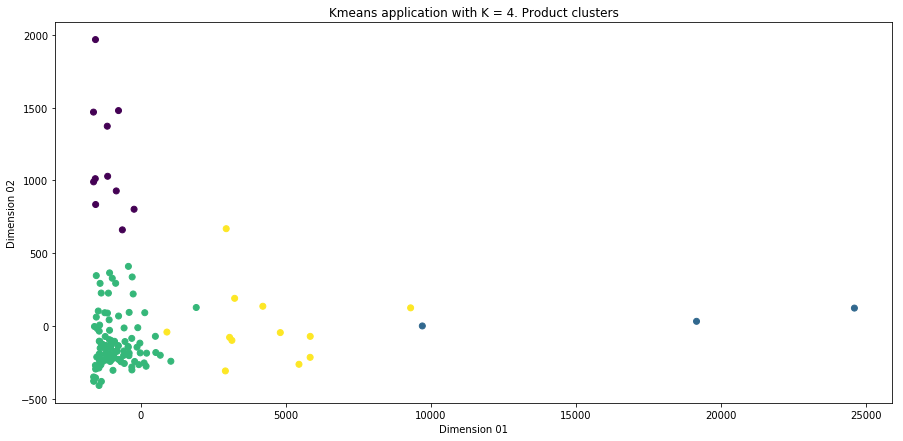

In [29]:
from sklearn.decomposition import PCA
# from mpl_toolkits.mplot3d import Axes3D

df4 = product_dataset[product_dataset.columns.difference(['code'])]
pca = PCA(n_components=2).fit(df4)
pca_2d = pca.transform(df4)

plt.figure(figsize=(15,7))
plt.scatter(pca_2d[:, 0], pca_2d[:, 1], c=labels)
plt.title("Kmeans application with K = 4. Product clusters")
plt.xlabel("Dimension 01")
plt.ylabel("Dimension 02")
plt.show()

## Cluster evaluation

The evaluation metric defined for this project is the silhouette score. The code below shows that the new implementation of KMeans, using new features and elbow method to define best value of K got a result of `0.53` for silhouette score, which is higher than the results gotten by benchmark model, showing that this new implementation created more appropriate clusters for the products. 

In [58]:
score = silhouette_score(df3, labels, metric='euclidean')

print("silhouette score is: {:.2f}".format(score))

silhouette score is: 0.53


## Conclusion

In this project we developed a cluster solution for grouping Magazine Luiza's products according to their features. We defined an input dataset with one product per line and all their features in the columns. All the transformations in the data were performed and all the features used by the benchmark model were reproduced and new features were created based on the dummy vars of `process_status` and `order_status`.

Later, the elbow method was used to define the best value of K. The technique showed that the best is `K=4`. KMeans was applied and the clusters were interpreted. Then silhouette score was applied to the results and this new implementation of KMeans got better results than the benchmark model. 

It's possible to note some future opportunities. They are listed below:

* Use features related to special events during the year, such as a numerical feature that counts how many times a product was purchased during the Easter, Black Friday, Promotional Days and so on
* Use categorical features along with the numerical ones. For example, it's possible to define dummy vars for each product `category` or `source_channel`. In this case, we would probably need to use **K-prototypes** as an algorithm to handle both numerical and categorical features
* Explore different cluster techniques and check their results. Gaussian Mixture Model and DBSCAN are good examples that could be tried to solve the problem. DBSCAN has the advantage that it does not assume clusters are convex shaped

## References

* [1] Huang, Z.: Clustering large data sets with mixed numeric and categorical values, Proceedings of the First Pacific Asia Knowledge Discovery and Data Mining Conference, Singapore, pp. 21-34, 1997.

* [2] Steinley, D.: K-means clustering: A half-century synthesis. British Journal of Math- ematical and Statistical Psychology 59(1), 1{34 (2006)

* [3] Wang, Fei & Franco, Hector & Pugh, John & Ross, Robert. (2016). Empirical Comparative Analysis of 1-of-K Coding and K-Prototypes in Categorical Clustering.

* [4] https://yurongfan.wordpress.com/2017/02/04/a-summary-of-different-clustering-methods/ (uso da silhueta para K-prototype)

* [5] https://thiagorodrigo.com.br/artigo/liquidacao-fantastica-2017-na-magazine-luiza-da-ate-70-de-desconto/

* [6] https://github.com/nicodv/kmodes

* [7] http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

* [8] https://en.wikipedia.org/wiki/Elbow_method_(clustering)

* [9] https://www.quora.com/How-can-we-choose-a-good-K-for-K-means-clustering

* [10] Bontempi G., Ben Taieb S., Le Borgne YA. (2013) Machine Learning Strategies for Time Series Forecasting. In: Aufaure MA., Zimányi E. (eds) Business Intelligence. eBISS 2012. Lecture Notes in Business Information Processing, vol 138. Springer, Berlin, Heidelberg

* [11] https://machinelearningmastery.com/time-series-forecast-study-python-monthly-sales-french-champagne/